In [5]:
# Additional code used for investigating the effects of birefringent block rotations inside the system

import matplotlib.pyplot as plt
import scipy.integrate as scpy
import numpy as np
import sys

# Constants
n         = 1.4904         # Normal refractive index
deltaC    = 5.32*10**(-12) # Stress optic coeff diff
Cx        = 4.01*10**(-7)  # Some stress optic coeff
Cy        = Cx + deltaC    # Some stress optic coeff
testSigma = 1000           # Stress applied to block
thickness = 0.06           # Thickness of the sample 

class light_ray():
    def __init__(self, polar, xdir = np.array([[0],[0]]), ydir = np.array([[0],[0]]), wavelength = 700 * 10**(-9), laserFWHM = 0.001):
        # Physical characteristics
        self.wavenumber = 2*np.pi/wavelength
        self.wavelength = wavelength 
        self.FWHM       = laserFWHM
        self.polarinit  = polar
        self.intensity = 0
        
        # Positional characteristics
        self.offset = np.array([0,0])
        self.polar = polar
        self.xdir  = xdir
        self.ydir  = ydir

        # Update the values
        self.update_values(polar)

        # Laser Gaussian profile characteristics
        self.gaussianProfile = lambda r,th: ((2*np.sqrt(np.log(2))/(laserFWHM*np.sqrt(np.pi)))) * np.exp(-(4*np.log(2)*np.linalg.norm((np.array([r*np.cos(th),r*np.sin(th)])-self.offset))**2)/(laserFWHM**2))
        
    def update_values(self, input_laser):
        self.compute_intensity(input_laser)
        self.offset = np.array([self.xdir[0],self.ydir[0]])
        self.gaussianProfile = lambda r,th: ((2*np.sqrt(np.log(2))/(self.FWHM*np.sqrt(np.pi)))) * np.exp(-(4*np.log(2)*np.linalg.norm((np.array([r*np.cos(th),r*np.sin(th)])-self.offset))**2)/(self.FWHM**2))
        
    def add_polarizer(self, angle):
        '''Adds a polarizer to the system matrix'''
        # Construct the polarizer matrix
        polarizerMatrix = np.array([[np.cos(angle)*np.cos(angle), np.cos(angle)*np.sin(angle)],
                                    [np.cos(angle)*np.sin(angle), np.sin(angle)*np.sin(angle)]])
        
        # Return the system matrix with the polarizer multiplied to the left
        self.polar =  polarizerMatrix @ self.polar 

    def add_birefringent_block(self, xangle, yangle, nx, ny, thickness):
        '''Adds a birefringent block to the system'''
        xInterfaceOffset = np.array([[0],[xangle]])
        yInterfaceOffset = np.array([[0],[yangle]])
        
        xRefractedMatrx1 = np.array([[1,0],[0,1/nx]])
        yRefractedMatrx1 = np.array([[1,0],[0,1/ny]])
        polarRfrctMatrx1 = np.array([[1,0],[0,1]])

        rTransmittedMtrx = np.array([[1,thickness],[0,1]])
        polarTransMatrix = np.array([[np.e**(complex(imag=1)*nx*self.wavenumber*thickness),0],[0,np.e**(complex(imag=1)*ny*self.wavenumber*thickness)]])
        
        xRefractedMatrx2 = np.array([[1,0],[0,nx]])
        yRefractedMatrx2 = np.array([[1,0],[0,ny]])
        polarRfrctMatrx2 = np.array([[np.e**(complex(imag=1)*np.pi),0],[0,np.e**(complex(imag=1)*np.pi)]])

        # Refraction through the first interface
        self.xdir  = xRefractedMatrx1 @ (self.xdir - xInterfaceOffset) + xInterfaceOffset
        self.ydir  = yRefractedMatrx1 @ (self.ydir - yInterfaceOffset) + yInterfaceOffset
        self.polar = polarRfrctMatrx1 @ self.polar

        # Transmission through the block (distance = thickness / cos angle approx = thickness for paraxial rays)
        self.xdir  = rTransmittedMtrx @ self.xdir
        self.ydir  = rTransmittedMtrx @ self.ydir
        self.polar = polarTransMatrix @ self.polar

        # Refraction through the second interface
        self.xdir  = xRefractedMatrx2 @ (self.xdir - xInterfaceOffset) + xInterfaceOffset
        self.ydir  = yRefractedMatrx2 @ (self.ydir - yInterfaceOffset) + yInterfaceOffset
        self.polar = polarRfrctMatrx2 @ self.polar

    def add_transmission(self, distance):
        '''Adds a transmission through air'''
        rTransmittedMtrx = np.array([[1,distance],[0,1]])
        self.xdir  = rTransmittedMtrx @ self.xdir
        self.ydir  = rTransmittedMtrx @ self.ydir
        
    def add_pinhole (self, radius):
        '''Adds a pinhole of a given radius'''
        # Integrate over the pinhole
        self.update_values(self.polarinit)

        intensityMod         = scpy.dblquad(self.gaussianProfile, 0, 2*np.pi, lambda x: 0, lambda x: radius)
        self.polar           = np.sqrt(intensityMod[0]) * self.polar
        
        self.gaussianProfile = lambda r,th: intensityMod[0] * self.gaussianProfile(r,th)

    def compute_intensity (self, input_laser):
        '''Gets the intensity of the laser'''
        # Compute the outgoing laser matrix
        going_laser = self.polar
        
        # Compute the outgoing/incoming laser intensities
        h_conj_buff = going_laser.transpose()
        h_conj_buff = h_conj_buff.conjugate()
        going_intensity = h_conj_buff @ going_laser

        h_conj_buff = input_laser.transpose()
        h_conj_buff = h_conj_buff.conjugate()
        input_intensity = h_conj_buff @ input_laser

        # Divide the two to normalize the going laser, return the value
        norm_intensity = going_intensity[0][0]/input_intensity[0][0]
        if norm_intensity.imag == 0:
            norm_intensity = norm_intensity.real
        else:
            print("Something went wrong: complex normalized intensity")
        
        self.intensity = norm_intensity

xangles = np.linspace(-5*(np.pi/180), 5*(np.pi/180), 31)
yangles = np.linspace(-5*(np.pi/180), 5*(np.pi/180), 31)

X, Y    = np.meshgrid(xangles,yangles)
Z       = np.empty_like(X)

inPolar = np.array([[1],[1]]) # Input laser

for xangle in xangles:
    for yangle in yangles:
        # Create the beam object (post - Polarizer 1)
        mainBeam = light_ray(polar=inPolar)
        
        # Make it go through the system
        mainBeam.add_birefringent_block(xangle, yangle, n+Cx*testSigma, n+Cy*testSigma, thickness)
        mainBeam.add_transmission(0.05)
        mainBeam.add_pinhole(0.002)
        mainBeam.add_polarizer(3*np.pi/4)
        
        # Compute the intensity and save it in the Z matrix
        mainBeam.compute_intensity(inPolar)       
        Z[list(xangles).index(xangle), list(yangles).index(yangle)] = mainBeam.intensity
        
        # Print the progress and keep going
        sys.stdout.write("\r Progress: {} %".format(round(100*(len(yangles)*(list(xangles).index(xangle))+list(yangles).index(yangle)+1)/(len(xangles)*len(yangles)),2)))
        sys.stdout.flush()


 Progress: 100.0 %

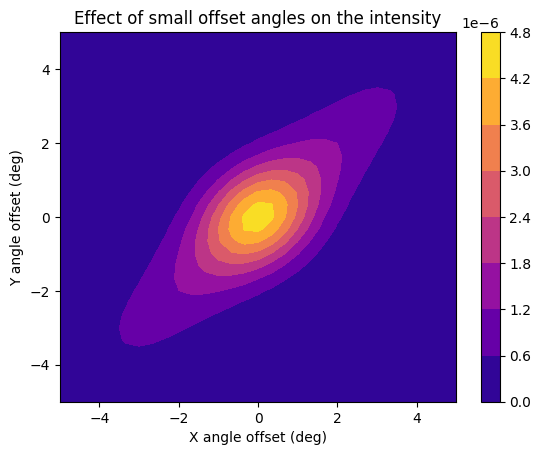

In [7]:
# Plot the results
plt.contourf(X*(180/np.pi),Y*(180/np.pi),Z, cmap = 'plasma')
plt.colorbar()
plt.xlabel("X angle offset (deg)")
plt.ylabel("Y angle offset (deg)")
plt.title ("Effect of small offset angles on the intensity")
plt.show()

In [ ]:
# Save the computed data
# not yet implemented